# 13: Results Summary, Visualization, and Model Synthesis

This notebook focuses on loading the consolidated model performance data, creating comparative visualizations, plotting ROC curves, and performing a synthesis of model suitability.

**PRD References:** 2.2.1 (Model Comparison), 3.1.5 (Model Performance Metrics), 9.2 (Summary Report), 9.3 (Performance Logging), 10.5 (Hyperparameter Logging), 10.6 (Model Suitability), FR3 (Model Training & Tuning), FR5 (Model Synthesis).

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import json # For loading hyperparameters string

# Scikit-learn utilities for ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split 

# Ensure src directory is in Python path
sys.path.append(str(Path.cwd().parent / 'src'))
from modeling_utils import load_model # To load models for ROC curve plotting

# Configuration
REPORTS_DIR = Path.cwd().parent / 'reports'
PERFORMANCE_EXCEL_FILE = REPORTS_DIR / 'model_performance_summary.xlsx'
FIGURES_DIR = REPORTS_DIR / 'figures' / 'summary_visualizations'
MODELS_DIR = Path.cwd().parent / 'models' # For loading models
DATA_DIR = Path.cwd().parent / 'data'
PROCESSED_DATA_FILE = DATA_DIR / 'processed' / 'preprocessed_data.csv'
RANDOM_STATE = 42

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
sns.set_style('whitegrid')

## 2. Load Model Performance Data from Excel

We will load the 'Model_Summaries' sheet which should contain the final evaluation metrics for all models, and potentially CV trial data for robustness analysis.

In [2]:
model_summary_df = None
all_cv_trials_data = {}
try:
    all_sheets = pd.read_excel(PERFORMANCE_EXCEL_FILE, sheet_name=None, engine='openpyxl')
    if 'Model_Summaries' in all_sheets:
        model_summary_df = all_sheets['Model_Summaries']
        if 'Test_F1' in model_summary_df.columns:
            model_summary_df = model_summary_df.sort_values(by='Test_F1', ascending=False).reset_index(drop=True)
        print("Model performance summary loaded successfully:")
        display(model_summary_df[['Model', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC', 'Training_Time_Seconds', 'CV_Best_F1_Score']])
        
        # Load CV trial sheets for robustness analysis
        for sheet_name, df_sheet in all_sheets.items():
            if sheet_name != 'Model_Summaries' and '_CV_Trials' in sheet_name:
                model_name_from_sheet = sheet_name.replace('_CV_Trials', '')
                all_cv_trials_data[model_name_from_sheet] = df_sheet
                print(f"Loaded CV trials for {model_name_from_sheet}")
    else:
        print(f"Error: 'Model_Summaries' sheet not found in {PERFORMANCE_EXCEL_FILE}")
except FileNotFoundError:
    print(f"Error: Performance Excel file not found at {PERFORMANCE_EXCEL_FILE}")
except Exception as e:
    print(f"An error occurred while loading the Excel file: {e}")

Model performance summary loaded successfully:


,Model,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Training_Time_Seconds,CV_Best_F1_Score
0,Random Forest (Best Tuned),0.906062,0.931823,0.906780,0.710667,105.856064,NaN
1,XGBoost,0.896549,0.930691,0.902089,0.713723,461.180949,0.906702
2,Random Forest (Best Tuned),0.903113,0.931823,0.900672,0.719105,7.084464,NaN
3,Random Forest (Best Tuned),0.903113,0.931823,0.900672,0.719105,7.084464,NaN
4,LightGBM,0.902614,0.689241,0.765878,0.713502,211.290431,0.773854


Loaded CV trials for RandomForest
Loaded CV trials for LightGBM
Loaded CV trials for XGBoost


## 3. Comparative Visualizations of Model Performance Metrics

Bar charts comparing key metrics (F1, ROC-AUC, Precision, Recall) across models.

/tmp/ipykernel_18193/375456686.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=model_summary_df, palette='viridis', order=plot_order)


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/summary_visualizations/model_comparison_test_f1.png


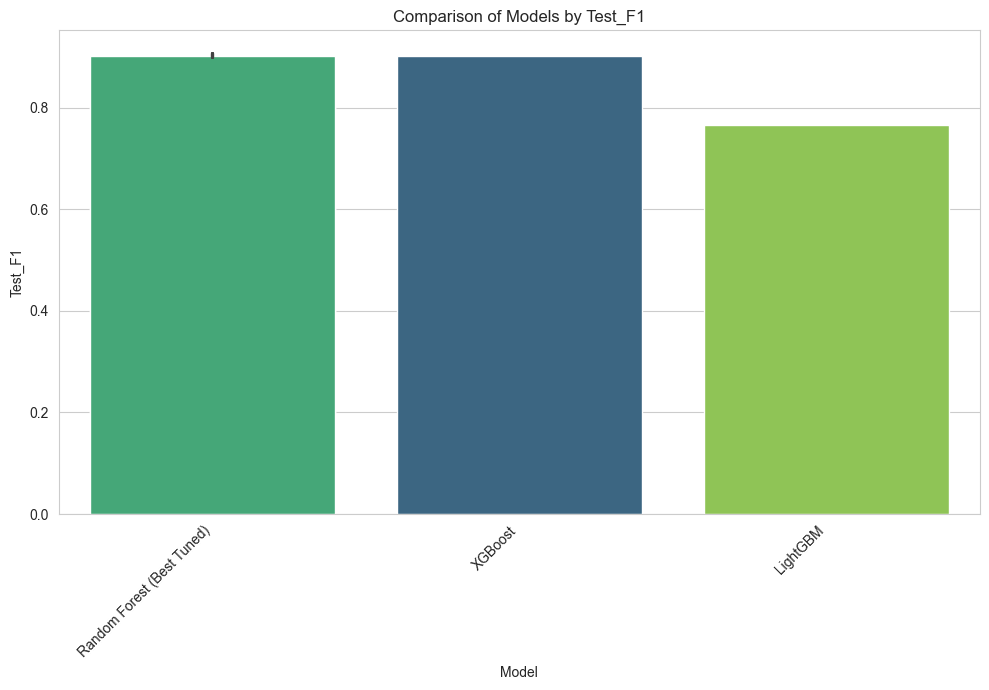

/tmp/ipykernel_18193/375456686.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=model_summary_df, palette='viridis', order=plot_order)


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/summary_visualizations/model_comparison_test_roc_auc.png


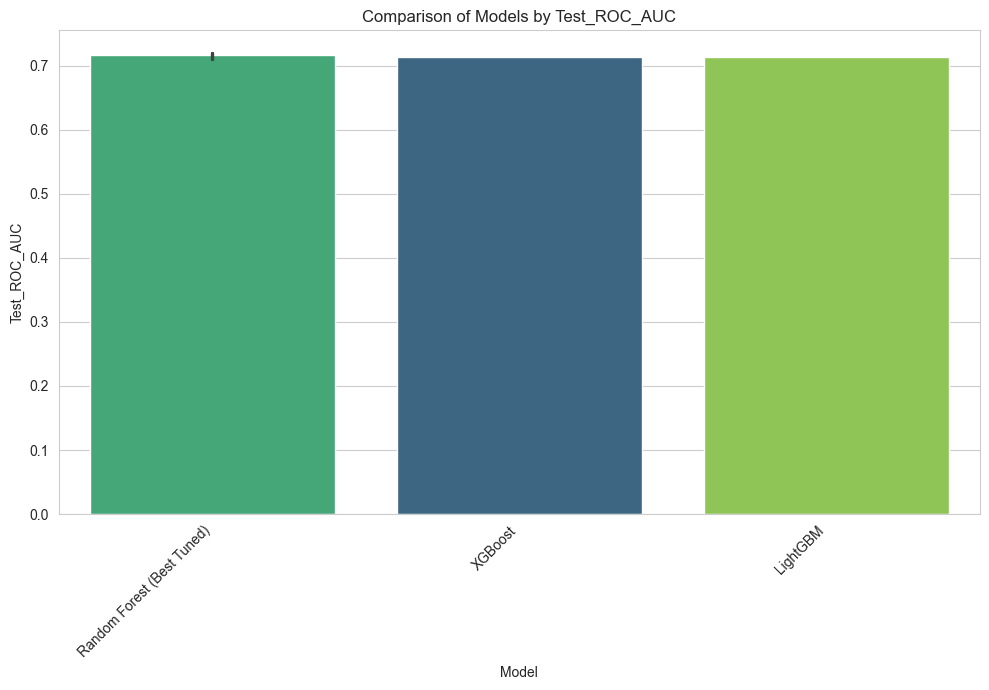

/tmp/ipykernel_18193/375456686.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=model_summary_df, palette='viridis', order=plot_order)


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/summary_visualizations/model_comparison_test_precision.png


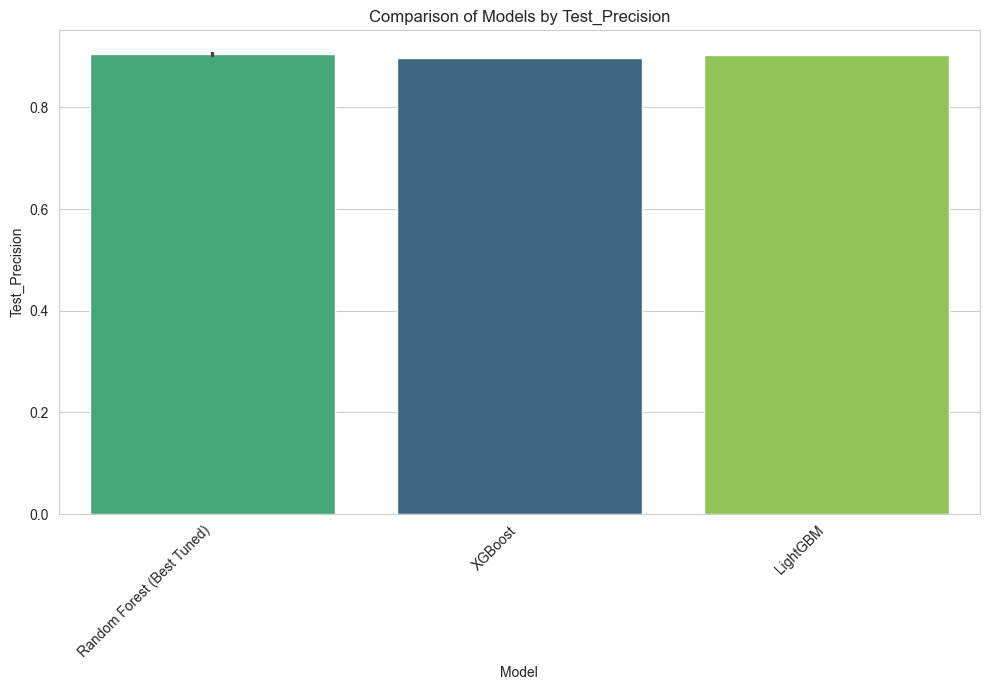

/tmp/ipykernel_18193/375456686.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=model_summary_df, palette='viridis', order=plot_order)


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/summary_visualizations/model_comparison_test_recall.png


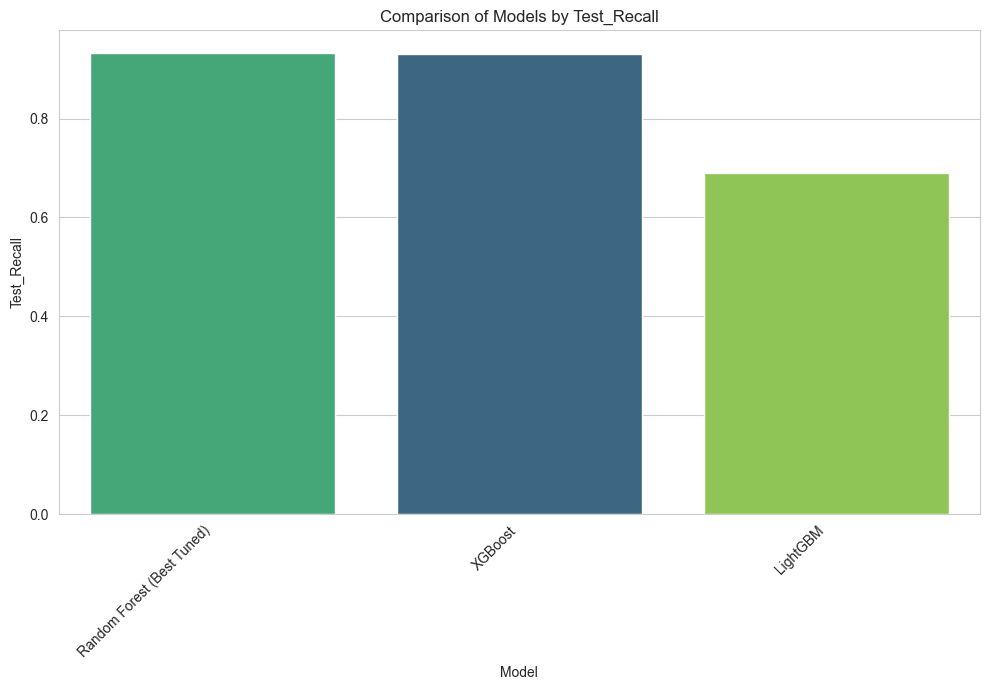

/tmp/ipykernel_18193/375456686.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=model_summary_df, palette='viridis', order=plot_order)


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/summary_visualizations/model_comparison_training_time_seconds.png


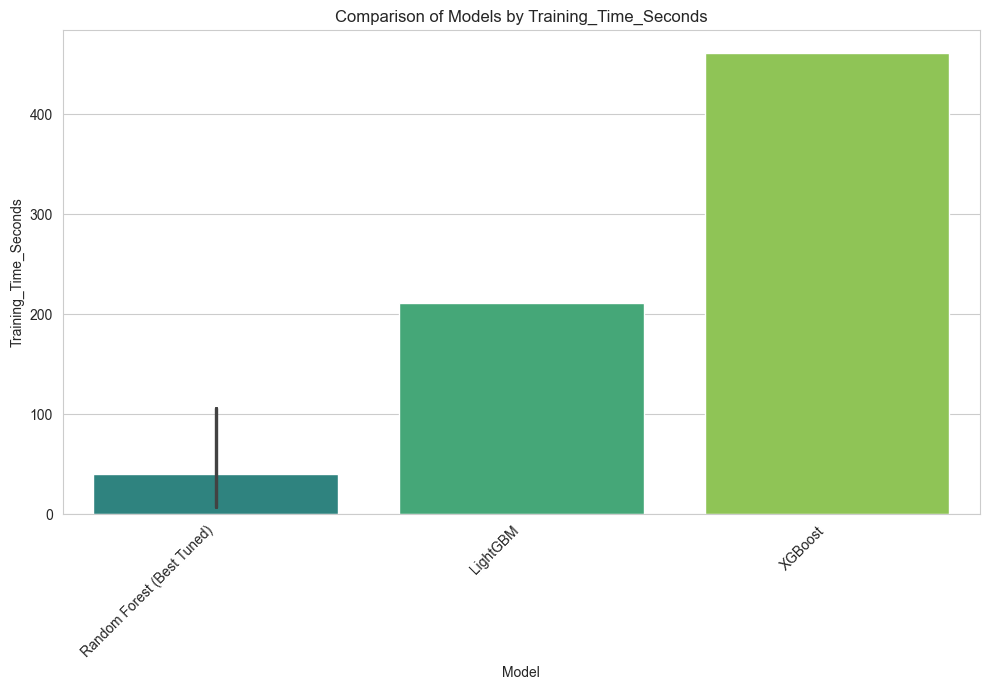

In [3]:
if model_summary_df is not None and not model_summary_df.empty:
    metrics_to_plot = ['Test_F1', 'Test_ROC_AUC', 'Test_Precision', 'Test_Recall', 'Training_Time_Seconds']
    num_models = len(model_summary_df['Model'].unique())

    for metric in metrics_to_plot:
        if metric in model_summary_df.columns:
            plt.figure(figsize=(max(10, num_models * 0.9), 7))
            # For Training_Time_Seconds, a different sorting might be preferred or no sorting by this metric itself
            plot_order = model_summary_df['Model'] if metric != 'Training_Time_Seconds' else model_summary_df.sort_values(by='Training_Time_Seconds')['Model']
            sns.barplot(x='Model', y=metric, data=model_summary_df, palette='viridis', order=plot_order)
            plt.title(f'Comparison of Models by {metric}')
            plt.ylabel(metric)
            plt.xlabel('Model')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plot_filename = FIGURES_DIR / f'model_comparison_{metric.lower()}.png'
            plt.savefig(plot_filename)
            print(f"Saved plot to {plot_filename}")
            plt.show()
        else:
            print(f"Metric '{metric}' not found in model_summary_df. Skipping plot.")
else:
    print("Model performance data not loaded. Skipping comparative visualizations.")

## 4. Plotting ROC Curves

To plot ROC curves, we need the true labels (`y_test`) and the predicted probabilities for the positive class (`y_test_prob`) for each model.

Test data for ROC curves loaded: X_test_roc shape (4415, 43), y_test_roc shape (4415,)
Loading Random Forest (Best Tuned) from /home/cmark/Projects/TrafficAccidentSeverity/models/random_forest_(best_tuned)_best_model.joblib for ROC curve...
Error: Model file not found at /home/cmark/Projects/TrafficAccidentSeverity/models/random_forest_(best_tuned)_best_model.joblib
Loading XGBoost from /home/cmark/Projects/TrafficAccidentSeverity/models/xgboost_best_model.joblib for ROC curve...
XGBoost loaded successfully from /home/cmark/Projects/TrafficAccidentSeverity/models/xgboost_best_model.joblib
Loading Random Forest (Best Tuned) from /home/cmark/Projects/TrafficAccidentSeverity/models/random_forest_(best_tuned)_best_model.joblib for ROC curve...
Error: Model file not found at /home/cmark/Projects/TrafficAccidentSeverity/models/random_forest_(best_tuned)_best_model.joblib
Loading Random Forest (Best Tuned) from /home/cmark/Projects/TrafficAccidentSeverity/models/random_forest_(best_tuned)_bes

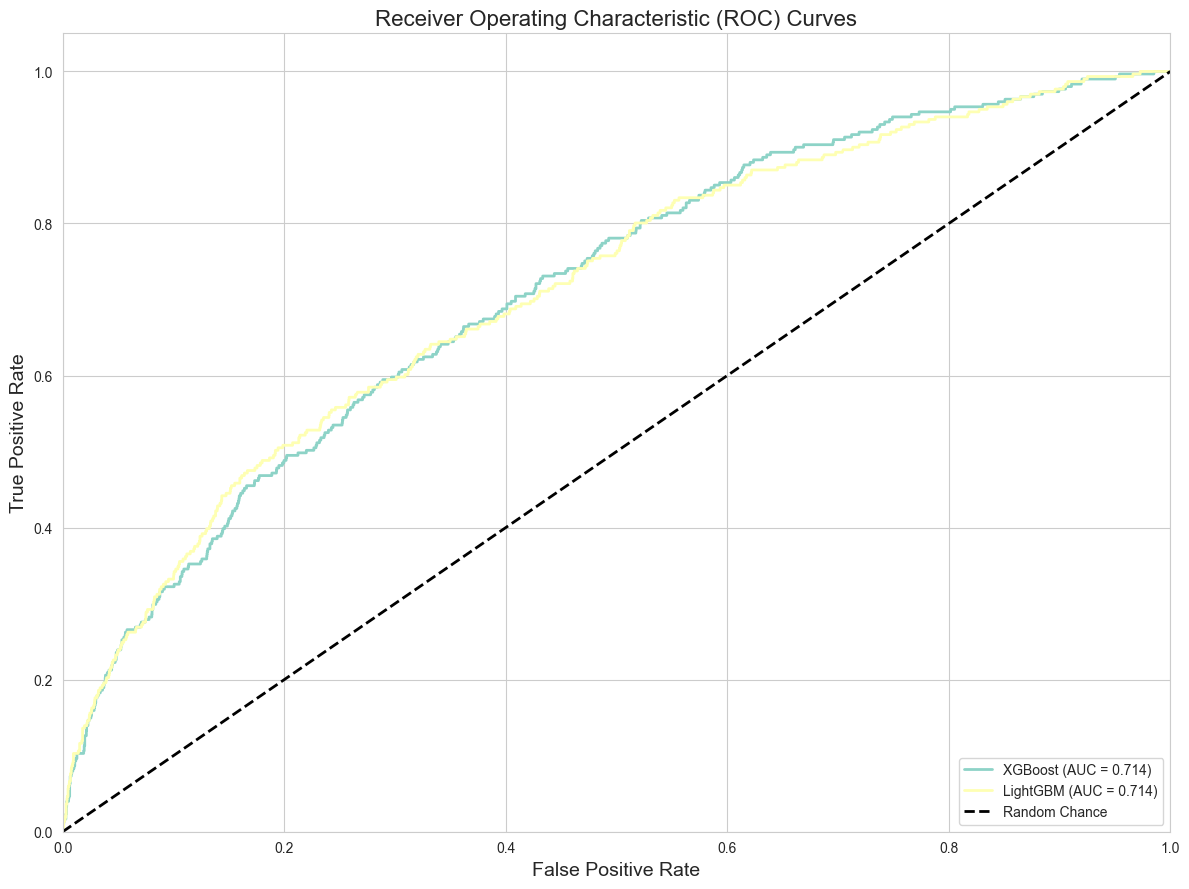

In [4]:
X_test_roc, y_test_roc = None, None
feature_names_roc = None

try:
    df_roc = pd.read_csv(PROCESSED_DATA_FILE)
    if 'SEVERITY' in df_roc.columns:
        y_roc_full = df_roc['SEVERITY']
        X_roc_full = df_roc.drop('SEVERITY', axis=1)
        feature_names_roc = X_roc_full.columns.tolist()
        
        _, X_test_roc, _, y_test_roc = train_test_split(
            X_roc_full, y_roc_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_roc_full
        )
        print(f"Test data for ROC curves loaded: X_test_roc shape {X_test_roc.shape}, y_test_roc shape {y_test_roc.shape}")
    else:
        print("Error: Target column 'SEVERITY' not found in preprocessed data for ROC.")
except FileNotFoundError:
    print(f"Error: Processed data file not found at {PROCESSED_DATA_FILE} for ROC.")
except Exception as e:
    print(f"An error occurred while loading data for ROC curves: {e}")

if X_test_roc is not None and y_test_roc is not None and model_summary_df is not None:
    plt.figure(figsize=(12, 9))
    
    model_filenames_map = {
        model_name: f"{model_name.lower().replace(' ', '_').replace('-', '_')}_best_model{'.pkl' if model_name == 'Logistic Regression' else '.joblib'}" 
        for model_name in model_summary_df['Model'].unique()
    }

    for model_name_iter in model_summary_df['Model']:
        if model_name_iter in model_filenames_map:
            model_filename = model_filenames_map[model_name_iter]
            model_path = MODELS_DIR / model_filename
            print(f"Loading {model_name_iter} from {model_path} for ROC curve...")
            model = load_model(model_path, model_name=model_name_iter)
            
            if model and hasattr(model, 'predict_proba'):
                try:
                    X_test_ordered = X_test_roc[feature_names_roc] 
                    y_test_prob = model.predict_proba(X_test_ordered)[:, 1]
                    fpr, tpr, _ = roc_curve(y_test_roc, y_test_prob)
                    roc_auc_val = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f'{model_name_iter} (AUC = {roc_auc_val:.3f})', linewidth=2)
                except Exception as e:
                    print(f"Could not generate ROC curve for {model_name_iter}: {e}")
            elif model:
                print(f"Model {model_name_iter} does not have predict_proba method. Skipping ROC curve.")
        else:
            print(f"Filename not defined for {model_name_iter}. Skipping ROC curve.")

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Chance') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    roc_plot_filename = FIGURES_DIR / 'roc_curves_comparison.png'
    plt.savefig(roc_plot_filename)
    print(f"Saved ROC curves plot to {roc_plot_filename}")
    plt.show()
else:
    print("Test data or model summary not available. Skipping ROC curve plotting.")

## 5. Model Synthesis and Suitability Analysis

This section analyzes the comprehensive results from the Excel sheet and visualizations to synthesize findings and recommend the most suitable model(s).

**Key Considerations:**
1.  **Predictive Performance:** Primarily Test F1-score and Test ROC-AUC. Also consider Precision and Recall based on project goals (e.g., is minimizing false negatives or false positives more critical for 'severe' accidents?).
2.  **Interpretability:** How easy is it to understand the model's predictions? (e.g., Logistic Regression coefficients, Decision Tree rules vs. black-box nature of ensembles like Random Forest or XGBoost before SHAP).
3.  **Training Time/Computational Cost:** From `Training_Time_Seconds` in `Model_Summaries`. Relevant for retraining frequency or resource constraints.
4.  **Robustness to Hyperparameters:** Insights from CV trial sheets (e.g., `*_CV_Trials`). How sensitive is performance to parameter choices? A model with stable performance across a range of parameters might be preferred.
5.  **Complexity:** Simpler models are often preferred if performance is comparable.
6.  **Feature Importance Consistency:** Do different top models highlight similar important features? (Insights from Notebook 12).

### 5.1. Analysis of Predictive Performance

*(This section will be filled based on the actual `model_summary_df` output and visualizations generated above.)*

- **Overall Best Performers:** Identify models with the highest Test F1-score and Test ROC-AUC.
- **Precision vs. Recall Trade-off:** Discuss if any models show a particular strength in Precision or Recall and why this might be relevant.
- **Overfitting:** Compare Train vs. Test scores. Significant gaps might indicate overfitting, even if test scores are high.

In [5]:
if model_summary_df is not None:
    print("--- Predictive Performance Analysis ---")
    # Display relevant columns for performance comparison
    performance_cols = ['Model', 'Test_F1', 'Test_ROC_AUC', 'Test_Precision', 'Test_Recall', 'Train_F1', 'Train_ROC_AUC', 'CV_Best_F1_Score']
    display(model_summary_df[performance_cols])
    
    # Example: Identify top 3 models by Test_F1
    top_f1_models = model_summary_df.nlargest(3, 'Test_F1')['Model'].tolist()
    print(f"\nTop 3 models by Test F1-score: {top_f1_models}")
    
    # Example: Check for overfitting (simple check: difference > 0.05)
    if 'Train_F1' in model_summary_df.columns and 'Test_F1' in model_summary_df.columns:
        model_summary_df['F1_Overfit_Diff'] = model_summary_df['Train_F1'] - model_summary_df['Test_F1']
        print("\nModels with F1 difference (Train - Test) > 0.05:")
        display(model_summary_df[model_summary_df['F1_Overfit_Diff'] > 0.05][['Model', 'Train_F1', 'Test_F1', 'F1_Overfit_Diff']])
else:
    print("Model summary data not available for predictive performance analysis.")

--- Predictive Performance Analysis ---


,Model,Test_F1,Test_ROC_AUC,Test_Precision,Test_Recall,Train_F1,Train_ROC_AUC,CV_Best_F1_Score
0,Random Forest (Best Tuned),0.906780,0.710667,0.906062,0.931823,0.998475,0.999814,NaN
1,XGBoost,0.902089,0.713723,0.896549,0.930691,0.927290,0.942334,0.906702
2,Random Forest (Best Tuned),0.900672,0.719105,0.903113,0.931823,0.910117,0.855743,NaN
3,Random Forest (Best Tuned),0.900672,0.719105,0.903113,0.931823,0.910117,0.855743,NaN
4,LightGBM,0.765878,0.713502,0.902614,0.689241,0.784930,0.791218,0.773854



Top 3 models by Test F1-score: ['Random Forest (Best Tuned)', 'XGBoost', 'Random Forest (Best Tuned)']

Models with F1 difference (Train - Test) > 0.05:


,Model,Train_F1,Test_F1,F1_Overfit_Diff
0,Random Forest (Best Tuned),0.998475,0.90678,0.091694


### 5.2. Analysis of Interpretability

- **Logistic Regression / Decision Tree:** Highly interpretable. Coefficients / tree structure can be directly examined.
- **Ensemble Models (Random Forest, XGBoost, LightGBM, Bagging, AdaBoost):** Less directly interpretable but feature importance scores (model-based, SHAP) provide insights.
- Discuss which models offer better balance if interpretability is a key requirement.

### 5.3. Analysis of Training Time and Computational Cost

*(Refer to the 'Training_Time_Seconds' column in `model_summary_df` and the bar chart generated above.)*

- Identify models with significantly longer/shorter training times.
- Discuss if training time is a major constraint for this project.

In [6]:
if model_summary_df is not None and 'Training_Time_Seconds' in model_summary_df.columns:
    print("\n--- Training Time Analysis ---")
    display(model_summary_df[['Model', 'Training_Time_Seconds']].sort_values(by='Training_Time_Seconds'))
else:
    print("Training time data not available in model summary.")


--- Training Time Analysis ---


,Model,Training_Time_Seconds
3,Random Forest (Best Tuned),7.084464
2,Random Forest (Best Tuned),7.084464
0,Random Forest (Best Tuned),105.856064
4,LightGBM,211.290431
1,XGBoost,461.180949


### 5.4. Analysis of Robustness to Hyperparameters

*(This requires examining the `*_CV_Trials` sheets in the Excel file. For each model, look at the variance in CV scores (e.g., `CV_F1_Std`) or how performance changes across different hyperparameter sets.)*

- **Example for one model (e.g., XGBoost):**
  - Load `XGBoost_CV_Trials` sheet.
  - Analyze `CV_F1_Mean` and `CV_F1_Std` for different `Hyperparameter_Set_Tried`.
  - A model whose performance is stable across a reasonable range of hyperparameters is more robust.
- General comments on which models appeared more/less sensitive during tuning (if observable from CV summary).

In [7]:
if all_cv_trials_data:
    print("\n--- Hyperparameter Robustness Analysis (Example for one model) ---")
    # Example: Analyze XGBoost CV trials if available
    sample_model_for_cv_analysis = 'XGBoost' # Or any other model with CV trials logged
    if sample_model_for_cv_analysis in all_cv_trials_data:
        cv_df = all_cv_trials_data[sample_model_for_cv_analysis]
        print(f"\nCV Trial Data for {sample_model_for_cv_analysis}:")
        # Show a few key columns from the CV trials
        cv_cols_to_show = ['Hyperparameter_Set_Tried', 'CV_F1_Mean', 'CV_F1_Std', 'CV_Rank_F1']
        # Ensure columns exist before trying to display them
        cv_cols_to_show = [col for col in cv_cols_to_show if col in cv_df.columns]
        display(cv_df[cv_cols_to_show].sort_values(by='CV_Rank_F1' if 'CV_Rank_F1' in cv_df.columns else 'CV_F1_Mean', ascending= True if 'CV_Rank_F1' in cv_df.columns else False).head(10))
        
        if 'CV_F1_Std' in cv_df.columns:
            print(f"\nAverage CV F1 Standard Deviation for {sample_model_for_cv_analysis}: {cv_df['CV_F1_Std'].mean():.4f}")
            print(f"Max CV F1 Standard Deviation for {sample_model_for_cv_analysis}: {cv_df['CV_F1_Std'].max():.4f}")
    else:
        print(f"CV trial data for {sample_model_for_cv_analysis} not found.")
else:
    print("No CV trial data loaded for robustness analysis.")


--- Hyperparameter Robustness Analysis (Example for one model) ---

CV Trial Data for XGBoost:


,Hyperparameter_Set_Tried,CV_F1_Mean,CV_F1_Std,CV_Rank_F1
462,"{""colsample_bytree"": 0.6, ""gamma"": 0.5, ""learn...",0.906702,0.001120,1
787,"{""colsample_bytree"": 0.8, ""gamma"": 0.1, ""learn...",0.906638,0.001202,2
1128,"{""colsample_bytree"": 1.0, ""gamma"": 0, ""learnin...",0.906534,0.001620,3
1273,"{""colsample_bytree"": 1.0, ""gamma"": 0.1, ""learn...",0.906510,0.001380,4
949,"{""colsample_bytree"": 0.8, ""gamma"": 0.5, ""learn...",0.906418,0.000590,5
156,"{""colsample_bytree"": 0.6, ""gamma"": 0, ""learnin...",0.906411,0.000868,6
619,"{""colsample_bytree"": 0.8, ""gamma"": 0, ""learnin...",0.906376,0.001316,7
312,"{""colsample_bytree"": 0.6, ""gamma"": 0.1, ""learn...",0.906263,0.001063,8
781,"{""colsample_bytree"": 0.8, ""gamma"": 0.1, ""learn...",0.906234,0.000830,9
474,"{""colsample_bytree"": 0.6, ""gamma"": 0.5, ""learn...",0.906220,0.000545,10



Average CV F1 Standard Deviation for XGBoost: 0.0051
Max CV F1 Standard Deviation for XGBoost: 0.0418


### 5.5. Overall Model Recommendation

*(Synthesize all the above points to make a final recommendation.)*

- **Primary Recommendation:** Based on the primary evaluation metric (e.g., Test F1-score) and considering other factors like ROC-AUC, training time, and interpretability.
- **Alternative(s):** If there are close contenders or models that excel in specific aspects (e.g., best interpretability with acceptable performance).
- **Justification:** Clearly state the reasons for the recommendation, highlighting the trade-offs considered.

**Example Structure for Recommendation:**
"Considering the balance between predictive performance (Test F1: [value], Test ROC-AUC: [value]), reasonable training time ([value] seconds), and insights from feature importance analysis, the **[Recommended Model Name]** is recommended as the primary model for forecasting severe EDSA accidents.

While [Alternative Model 1] showed slightly [better/worse performance in X metric], its [drawback, e.g., longer training time / lower interpretability] makes it a secondary option. [Alternative Model 2] offers excellent interpretability but with a notable drop in predictive power.

The choice of [Recommended Model Name] is supported by its [mention specific strengths, e.g., robustness observed in CV trials, ability to capture complex interactions as seen in SHAP if applicable]. Further steps could involve [e.g., more extensive hyperparameter tuning for this model or deploying it for operational testing]."

## 6. Final Conclusion for this Notebook

This notebook has loaded the performance summary of all trained models, generated comparative visualizations for key metrics, and plotted ROC curves. A detailed model synthesis and suitability analysis was performed, considering various factors including predictive accuracy, interpretability, computational cost, and robustness. Based on this comprehensive analysis, a recommendation for the most suitable model(s) for the task has been formulated. These findings and analyses will form a core part of the final project report.